In [64]:
from tabulate import tabulate
from tqdm import tqdm

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

In [66]:
import numpy as np
import pandas as pd

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
from fairness.utils import *
from fairness.mixture import *

In [69]:
%matplotlib inline

In [70]:
np.random.seed(85)

In [71]:
n, d = 1000, 10

In [72]:
p1, p0, p = .25, .5, .3

In [73]:
cov0 = np.diag(np.random.rand(d))
cov1 = np.eye(d)

In [74]:
mu00 = np.zeros(d); mu00[[0, -1]] = [-2, -2]
mu11 = np.zeros(d); mu11[[0, -1]] = [.5, -2]
mu01 = np.zeros(d); mu01[0] = -2
mu10 = np.zeros(d); mu10[0] = 1.3

In [75]:
args = (p0, p1, mu00, mu01, mu10, mu11, cov0, cov1)

We simulate a Gaussian mixture model with the following: 

        S ~ B(p)
        Y | S = 1 ~ B(p1)
        Y | S = 0 ~ B(p0)

        X | Y = 1, S = 1 ~ N(μ11, Σ1)
        X | Y = 1, S = 0 ~ N(μ10, Σ0)
        X | Y = 0, S = 1 ~ N(μ01, Σ1)
        X | Y = 0, S = 0 ~ N(μ00, Σ0)

In [76]:
X, s, y = generate_samples(n, d, p, *args)

We display the true unfairness of the synthetic data as a function of the probabilities of having a positive outcome while being part of the sensitive and non-sensitive group.

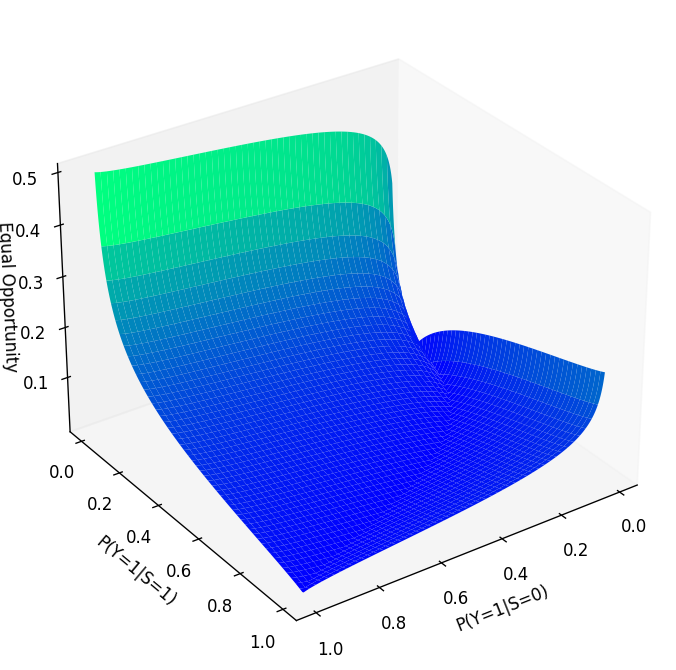

In [77]:
p0_span = np.linspace(.01, .99, 1000)
p1_span = np.linspace(.01, .99, 1000)

px, py = np.meshgrid(p0_span, p1_span)

fig = plt.figure(dpi=120, figsize=[7,7])
ax = plt.axes(projection='3d')
ax.grid(False)
ax.view_init(30, 55)
ax.zaxis.labelpad=-0.7
ax.plot_surface(px, py, equal_opportunity(np.ravel(px), np.ravel(py), mu00, mu01, mu10, mu11, cov0, cov1).reshape(1000, 1000), cmap='winter');
ax.set_xlabel('P(Y=1|S=0)');
ax.set_ylabel('P(Y=1|S=1)');
ax.set_zlabel('Equal Opportunity');


In [78]:
print(f'The fairness for this toy model is: {equal_opportunity(*args).item():.3f}')

The fairness for this toy model is: 0.103


In [79]:
def plot(X, y, s):
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot()
    s_mask = s == 1
    y_mask = y == 1
    
    ax.scatter(X[s_mask & y_mask, 0], X[s_mask & y_mask, 1], c='green', marker='_', s=33, label='S=1 & Y=1');
    ax.scatter(X[~s_mask & y_mask, 0], X[~s_mask & y_mask, 1], c='purple', alpha=.5, marker='+', s=33, label='S=0 & Y=1');
    ax.scatter(X[s_mask & ~y_mask, 0], X[s_mask & ~y_mask, 1], c='orange', marker='x', s=33, label='S=1 & Y=0');
    ax.scatter(X[~s_mask & ~y_mask, 0], X[~s_mask & ~y_mask, 1], c='red', marker='*', s=33, label='S=0 & Y=0');
    fig.legend(ncol=2, bbox_to_anchor=[.99, 1.15])
    fig.tight_layout()

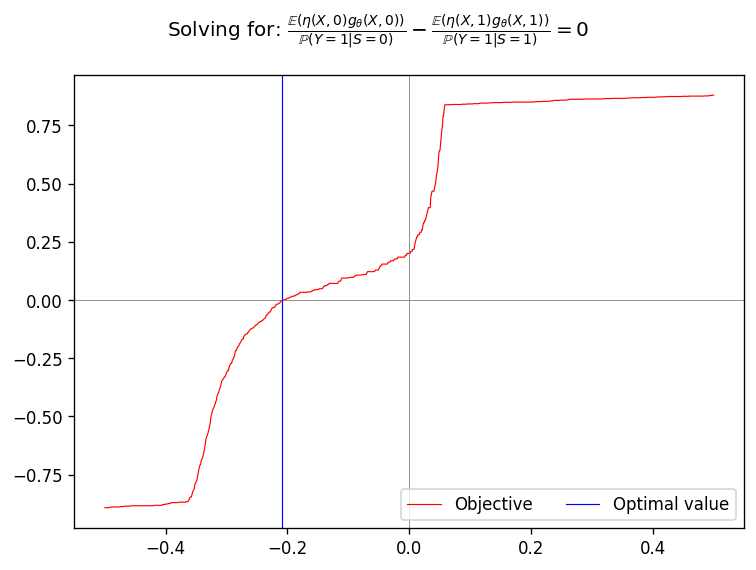

In [80]:
bayes_pred = bayes_classifier(X, s, *args)

estimated_args = estimate(X, y, s)

y_prob = regression_function(X, s, *estimated_args)
y_pred = (y_prob > .5).astype(int)

estim_acc = np.mean(y_pred == y)
bayes_acc = np.mean(bayes_pred == y)

bayes_fairness = empirical_unfairness(y, bayes_pred, s)
pred_fairness = empirical_unfairness(y, y_pred, s)

theta, value, y_calib = recalibrate_predictions(y_prob, s, max_iter=100)
calib_fairness = empirical_unfairness(y, y_calib, s)
calib_acc = np.mean(y == y_calib)

thetas = np.linspace(-.5, .5, 1000)
fig, ax = plt.subplots(dpi=120)
ax.plot(thetas, [objective(t, y_prob, s) for t in thetas], color='red', label='Objective', lw=.7)
ax.axvline(0, color='gray', lw=.5)
ax.axhline(0, color='gray', lw=.5)
ax.axvline(theta, color='b', label='Optimal value', lw=.7)
fig.suptitle(r'Solving for: $\frac{\mathbb{E}(\eta(X, 0)g_{\theta}(X, 0))}{\mathbb{P}(Y=1|S=0)} - \frac{\mathbb{E}(\eta(X, 1)g_{\theta}(X, 1))}{\mathbb{P}(Y=1|S=1)} = 0$')
fig.tight_layout()
ax.legend(ncol=2);
fig.savefig('recalibration.png')


In [81]:
f'Proportion of 0\'s in the prediction: {100 * np.mean(1-y_calib)} %'

"Proportion of 0's in the prediction: 57.099999999999994 %"

In [82]:
print(
    tabulate(
        [['Bayes', bayes_acc, bayes_fairness],
         ['Estimated', estim_acc, pred_fairness],
         ['Calibrated', calib_acc, calib_fairness]], 
        headers=['Accuracy', '(Un)fairness'], 
        tablefmt='grid',
        floatfmt='.2f'
    )
)

+------------+------------+----------------+
|            |   Accuracy |   (Un)fairness |
+============+============+================+
| Bayes      |       0.98 |           0.14 |
+------------+------------+----------------+
| Estimated  |       0.98 |           0.27 |
+------------+------------+----------------+
| Calibrated |       0.96 |           0.05 |
+------------+------------+----------------+


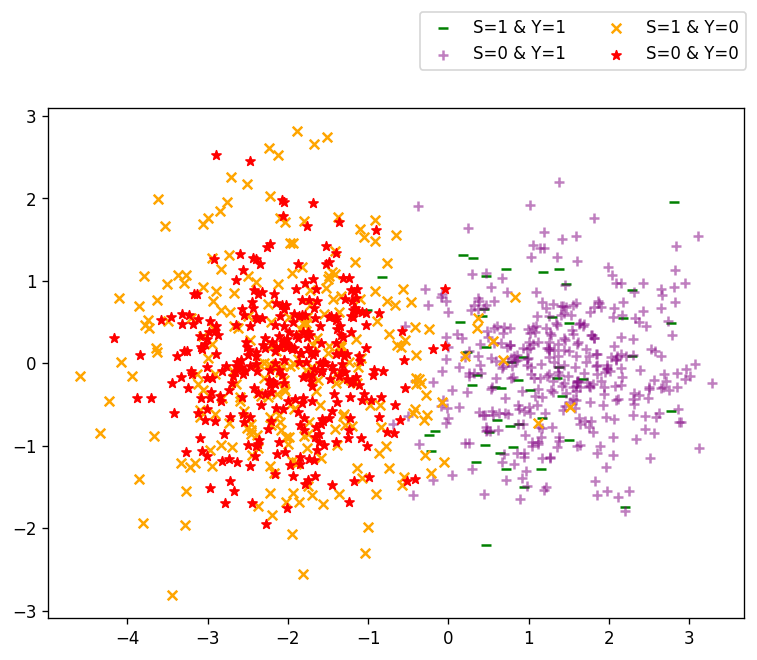

In [83]:
plot(X, y_pred, s)

In [104]:
testing_df = pd.DataFrame(
    columns=['Accuracy', '(Un)fairness'], 
    index=['1 / 10 Dn']+  [f'1 / 10 Dn + {i} / 10 DN' for i in range(1, 9)],
    dtype='double'
)

In [107]:
np.random.seed(85)
X_labeled, s_labeled, y_labeled = generate_samples(n, d, p , *args)
np.random.seed(None)
X_unlabeled, s_unlabeled, y_unlabeled = generate_samples(n, d, p , *args)

lab_index = np.random.choice(n, n // 10)

X = X_labeled[lab_index]
y = y_labeled[lab_index]
s = s_labeled[lab_index]
y_prob = regression_function(X, s, *estimated_args)
y_pred = (y_prob > .5).astype(int)

_, _, y_calib = recalibrate_predictions(y_prob, s, max_iter=100)
testing_df.loc['1 / 10 Dn', '(Un)fairness'] = empirical_unfairness(y, y_calib, s)
testing_df.loc['1 / 10 Dn', 'Accuracy'] = np.mean(y == y_calib)

for i in range(1, 9):

    X = np.concatenate([X, X_unlabeled[(i-1)*n//10: i*n//10+1]], axis=0)
    y = np.concatenate([y, y_unlabeled[(i-1)*n//10: i*n//10+1]], axis=0)
    s = np.concatenate([s, s_unlabeled[(i-1)*n//10: i*n//10+1]], axis=0)
    row = f'1 / 10 Dn + {i} / 10 DN'
    y_prob = regression_function(X, s, *estimated_args)
    y_pred = (y_prob > .5).astype(int)

    _, _, y_calib = recalibrate_predictions(y_prob, s, max_iter=100)
    testing_df.loc[row, '(Un)fairness'] = empirical_unfairness(y, y_calib, s)
    testing_df.loc[row, 'Accuracy'] = np.mean(y == y_calib)

In [108]:
print(tabulate(testing_df, tablefmt='grid', floatfmt='.2f', headers = testing_df.columns))

+-----------------------+------------+----------------+
|                       |   Accuracy |   (Un)fairness |
+=======================+============+================+
| 1 / 10 Dn             |       0.98 |           0.14 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 1 / 10 DN |       0.98 |           0.03 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 2 / 10 DN |       0.97 |           0.02 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 3 / 10 DN |       0.96 |           0.01 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 4 / 10 DN |       0.96 |           0.00 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 5 / 10 DN |       0.97 |           0.00 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 6 / 10 DN |       0.97 |           0.02 |
+-----------------------+------------+----------------+
| 1 / 10 Dn + 7 / 10 DN |       0.97 |          

In [119]:
n = 100
np.random.seed(85)
X, s, y = generate_samples(n, d, p , *args)
bayes_acc = []
estim_acc = []
bayes_deo = []
estim_deo = []
calib_acc = []
calib_deo = []

for i in tqdm(range(1000)):
    X_, s_, y_ = generate_samples(n, d, p , *args)

    X = np.concatenate([X, X_], axis=0)
    y = np.concatenate([y, y_])
    s = np.concatenate([s, s_])

    bayes_pred = bayes_classifier(X, s, *args)

    estimated_args = estimate(X, y, s)

    y_prob = regression_function(X, s, *estimated_args)
    y_pred = (y_prob > .5).astype(int)

    estim_acc.append(np.mean(y_pred == y))
    bayes_acc.append(np.mean(bayes_pred == y))

    bayes_deo.append(empirical_unfairness(y, bayes_pred, s))
    estim_deo.append(empirical_unfairness(y, y_pred, s))

    _, _, y_calib = recalibrate_predictions(y_prob, s)
    calib_deo.append(empirical_unfairness(y, y_calib, s))
    calib_acc.append(np.mean(y == y_calib))


100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s]


In [ ]:
x = np.arange(100, 100100, 100)

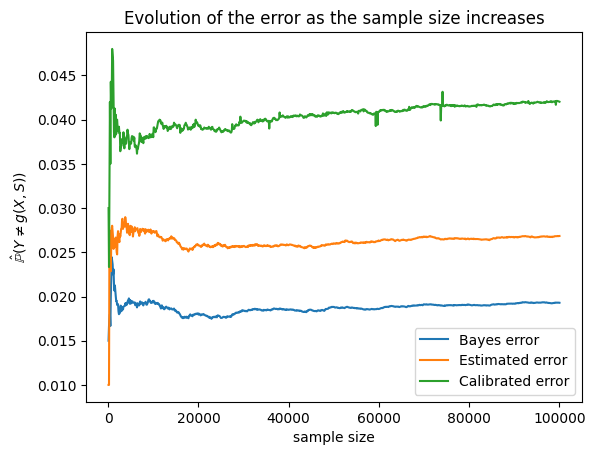

In [151]:
plt.plot(x, 1-np.asarray(bayes_acc), label='Bayes error')
plt.plot(x, 1-np.asarray(estim_acc), label='Estimated error')
plt.plot(x, 1-np.asarray(calib_acc), label='Calibrated error')
plt.legend()
plt.title('Evolution of the error as the sample size increases')
plt.xlabel('sample size: n')
plt.ylabel('$\hat\mathbb{P}(Y \\neq g(X, S))$');

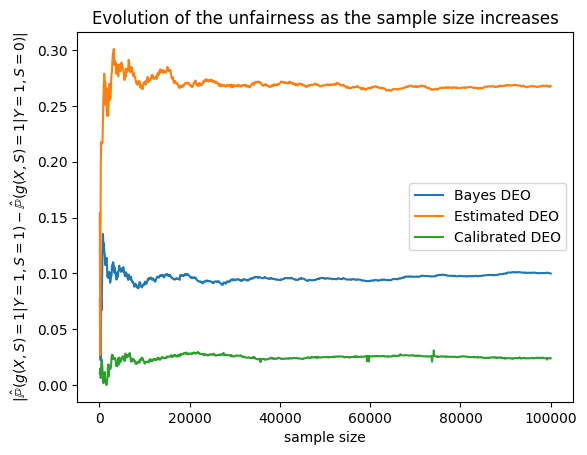

In [150]:

plt.plot(x, bayes_deo, label='Bayes DEO')
plt.plot(x, estim_deo, label='Estimated DEO')
plt.plot(x, calib_deo, label='Calibrated DEO')
plt.legend()
plt.title('Evolution of the unfairness as the sample size increases')
plt.xlabel('sample size: n')
plt.ylabel('$| \hat\mathbb{P}(g(X, S) = 1 | Y=1, S=1) - \hat\mathbb{P}(g(X, S) = 1 | Y=1, S=0)|$');